#### Load Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Input, GlobalAveragePooling2D, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import os
import itertools
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

tf.config.list_physical_devices('gpu')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices("GPU"))

%matplotlib inline


2024-03-19 00:31:43.437168: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-19 00:31:43.461479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 00:31:43.461506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 00:31:43.462122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 00:31:43.465978: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-19 00:31:44.666428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-19 00:31:44.690996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-19 00:31:44.691125: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

#### Set Path Variable

In [2]:
main_directory = '/home/dll-1/Desktop/eeg/datasets/Adil paper/scallogramTest'

class_labels = ['normal', 'slowing-wave', 'spike-and-wave']
class_labels = ['Normal', 'Slowing Waves', 'Spike and Sharp waves']  # Names of subfolders with in main folder

dest_list = ['Normal', 'Slowing Waves', 'Spike and Sharp waves']  # Names of subfolders with in main folder
waveletsTypes = ['mexh','morl', 'gaus1', 'gaus2']
splits = ['train', 'valid', 'test']

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)



#### Confusion Matrix

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
def plotImages(images_arr,train_labels):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    i=0
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(train_labels[i])
        i = i+1
    plt.tight_layout()
    plt.show()

# Model Implementation

### Prepare Callbacks

In [5]:
es = EarlyStopping(
    monitor = 'val_loss',
    patience = 4,
    verbose = 1,
    mode = 'auto'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,mode = 'auto',
                              patience=2, min_lr=0.00001,verbose = 1)

os.chdir(main_directory)

## Google LeNEt

In [6]:
##### Google LeNet

###### Build Model

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

def GoogLeNet():
    tf.keras.backend.clear_session()
    # input layer 
    input_layer = Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(3, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(3, activation = 'softmax')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(3, activation = 'softmax')(X)

    # model
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model



## Vgg16

In [7]:
def plot_accuracy_loss(loss,val_loss,accuracy,val_accuracy):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [8]:
def test_model(model,test_batches,model_type):

    y_test=test_batches.classes

    model.evaluate(test_batches)

    predictions = model.predict(test_batches, verbose = 2)

    if model_type == "googlenet":
        y_pred = np.argmax(predictions[1], axis = 1)
    else:
        y_pred = np.argmax(predictions, axis = 1)    

    cm = confusion_matrix(y_test, y_pred)

    cm_plot_labels = [0, 1, 2]
    plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

    print(accuracy_score(y_test, y_pred))

    target_names = ['class 0', 'class 1', 'class 2']
    print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

In [9]:
def evaluate_googlenet(google_lenet, train_batches,valid_batches,checkpoint_filepath):

    mc2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

    ###### Train Model
    history = google_lenet.fit(train_batches, validation_data = valid_batches ,callbacks=[es,mc2],epochs =30,shuffle = True)

    google_lenet.save(checkpoint_filepath+'/googlenet/GoogLenet_-final.h5')
    google_lenet.save_weights(checkpoint_filepath+'/googlenet/GoogLenet_-final.tf', save_format='tf')

    ###### Model Plots
    plot_accuracy_loss(history.history['dense_4_loss'],history.history['val_dense_4_loss'],history.history['dense_4_accuracy'],history.history['val_dense_4_accuracy'])

    return google_lenet


In [10]:
def evaluate_vgg16(vgg16_model_custom, train_batches,valid_batches,checkpoint_filepath):
    ###### Train Model
    history = vgg16_model_custom.fit(x = train_batches, validation_data = valid_batches, callbacks = [es], epochs = 30, verbose = 1,shuffle = True)

    vgg16_model_custom.save(checkpoint_filepath+'/vgg16/VGG16_baseline.h5')
    vgg16_model_custom.save_weights(checkpoint_filepath+'/vgg16/VGG16_baseline.tf', save_format='tf')

    plot_accuracy_loss(history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy'])

    return vgg16_model_custom

------------------- mexh -------------------------
Found 621367 images belonging to 3 classes.
Found 79698 images belonging to 3 classes.
Found 96630 images belonging to 3 classes.


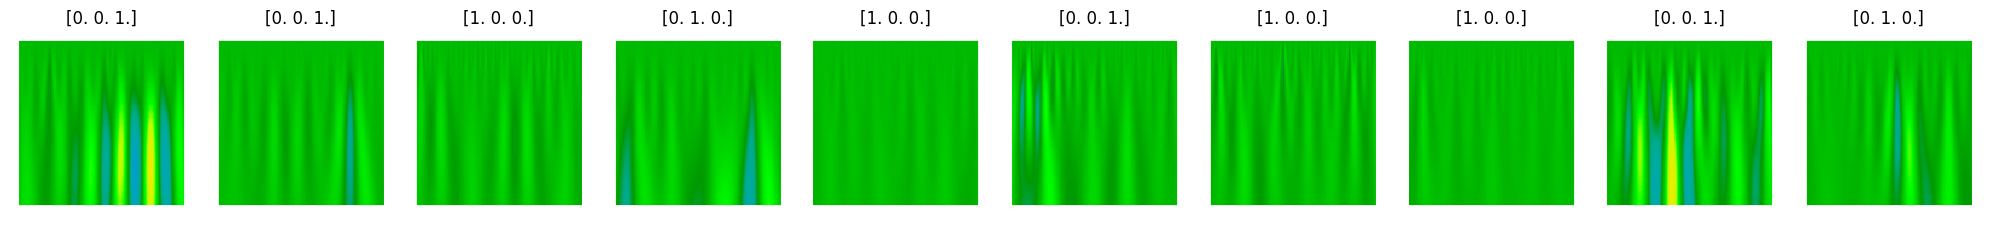

2024-03-19 00:31:48.864254: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-19 00:31:48.864392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-19 00:31:48.864445: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-03-19 00:31:55.243232: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-19 00:31:56.935292: I external/local_xla/xla/service/service.cc:168] XLA service 0x786205216b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-19 00:31:56.935315: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-19 00:31:56.938925: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710790316.998489 1741172 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19418/19418 [==============================] - 637s 32ms/step - loss: 1.5480 - dense_4_loss: 0.5075 - dense_1_loss: 0.5293 - dense_3_loss: 0.5113 - dense_4_accuracy: 0.7859 - dense_1_accuracy: 0.7754 - dense_3_accuracy: 0.7845 - val_loss: 1.8084 - val_dense_4_loss: 0.6033 - val_dense_1_loss: 0.6214 - val_dense_3_loss: 0.5837 - val_dense_4_accuracy: 0.7348 - val_dense_1_accuracy: 0.7266 - val_dense_3_accuracy: 0.7352
Epoch 2/30
19418/19418 [==============================] - 606s 31ms/step - loss: 1.3210 - dense_4_loss: 0.4317 - dense_1_loss: 0.4529 - dense_3_loss: 0.4364 - dense_4_accuracy: 0.8205 - dense_1_accuracy: 0.8131 - dense_3_accuracy: 0.8196 - val_loss: 1.7071 - val_dense_4_loss: 0.5703 - val_dense_1_loss: 0.5763 - val_dense_3_loss: 0.5605 - val_dense_4_accuracy: 0.7540 - val_dense_1_accuracy: 0.7376 - val_dense_3_accuracy: 0.7501
Epoch 3/30
19418/19418 [==============================] - 604s 31ms/step - loss: 1.2378 - dense_4_loss: 0.4046 - dense_1_loss: 0.4242 - dense_3_loss:

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


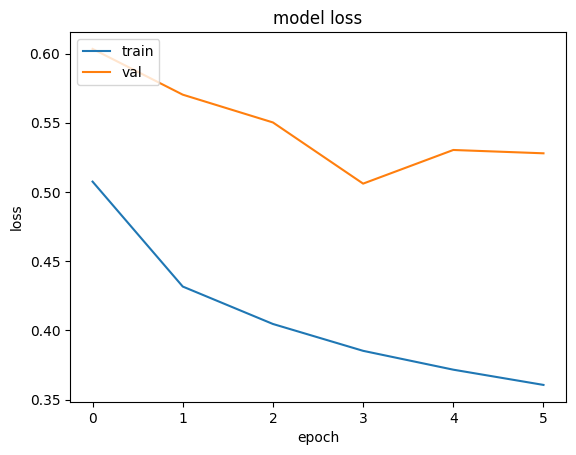

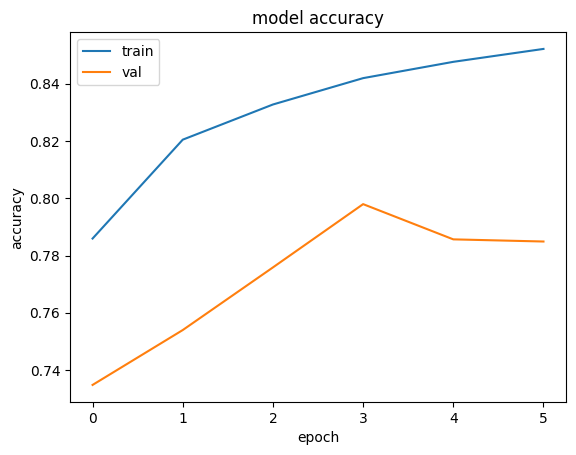

6040/6040 [==============================] - 64s 11ms/step - loss: 1.6403 - dense_4_loss: 0.5540 - dense_1_loss: 0.5350 - dense_3_loss: 0.5513 - dense_4_accuracy: 0.7642 - dense_1_accuracy: 0.7597 - dense_3_accuracy: 0.7610
6040/6040 - 63s - 63s/epoch - 10ms/step
Confusion matrix, without normalization
[[58699  3083  2482]
 [10131 10428  4558]
 [ 1084  1878  4287]]


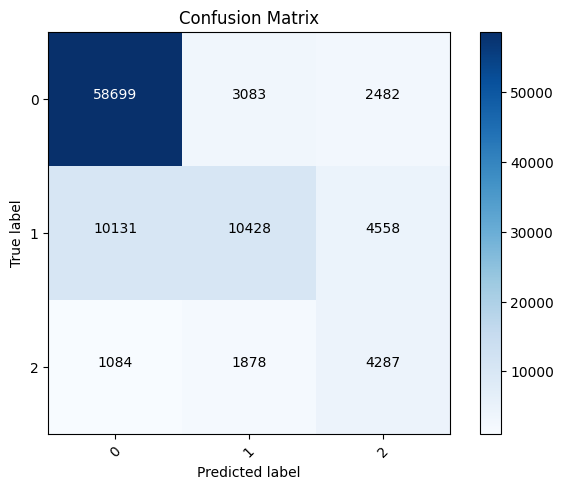

0.7597433509262134
              precision    recall  f1-score   support

     class 0    0.83959   0.91340   0.87494     64264
     class 1    0.67763   0.41518   0.51489     25117
     class 2    0.37848   0.59139   0.46156      7249

    accuracy                        0.75974     96630
   macro avg    0.63190   0.63999   0.61713     96630
weighted avg    0.76290   0.75974   0.75034     96630

Epoch 1/30
19418/19418 [==============================] - 2202s 113ms/step - loss: 0.4495 - accuracy: 0.8139 - val_loss: 0.5411 - val_accuracy: 0.7766
Epoch 2/30
19418/19418 [==============================] - 2175s 112ms/step - loss: 0.3813 - accuracy: 0.8440 - val_loss: 0.5565 - val_accuracy: 0.7771
Epoch 3/30
19418/19418 [==============================] - 2170s 112ms/step - loss: 0.3568 - accuracy: 0.8548 - val_loss: 0.5487 - val_accuracy: 0.7835
Epoch 3: early stopping


/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


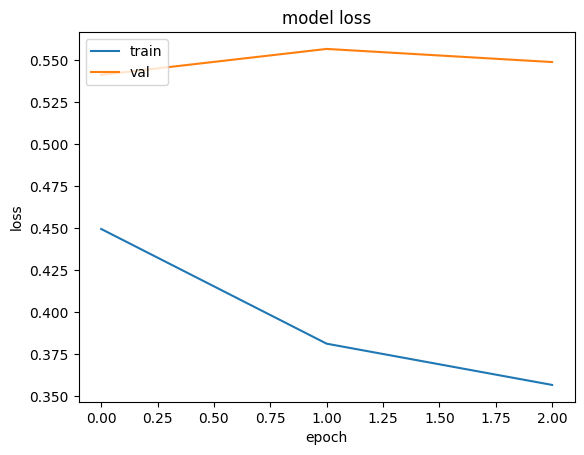

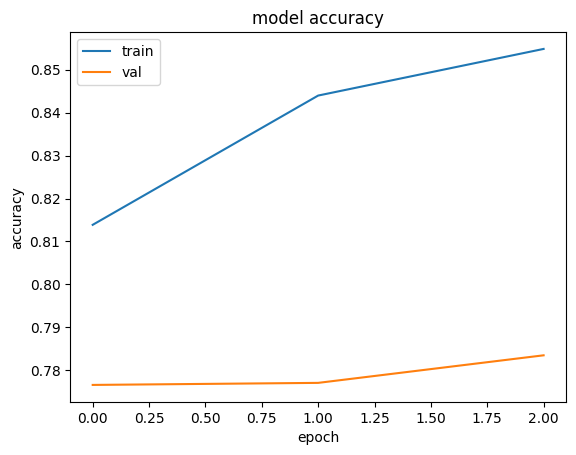

6040/6040 [==============================] - 136s 23ms/step - loss: 0.5885 - accuracy: 0.7469
6040/6040 - 129s - 129s/epoch - 21ms/step
Confusion matrix, without normalization
[[59886  2195  2183]
 [10801  7842  6474]
 [ 1333  1470  4446]]


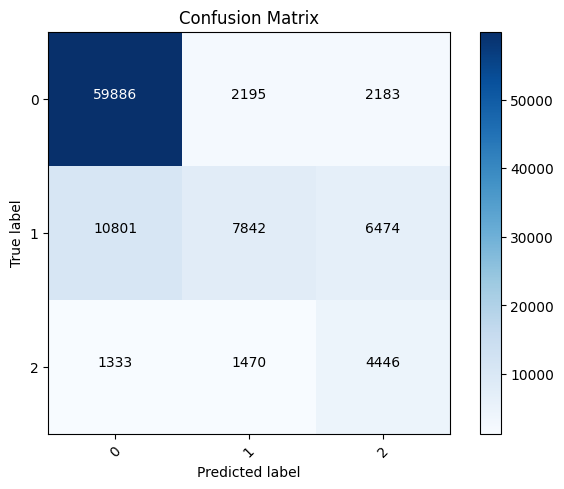

0.746910897236883
              precision    recall  f1-score   support

     class 0    0.83152   0.93187   0.87884     64264
     class 1    0.68150   0.31222   0.42824     25117
     class 2    0.33931   0.61333   0.43691      7249

    accuracy                        0.74691     96630
   macro avg    0.61744   0.61914   0.58133     96630
weighted avg    0.75560   0.74691   0.72856     96630

------------------- morl -------------------------
Found 453544 images belonging to 3 classes.
Found 66527 images belonging to 3 classes.
Found 96627 images belonging to 3 classes.


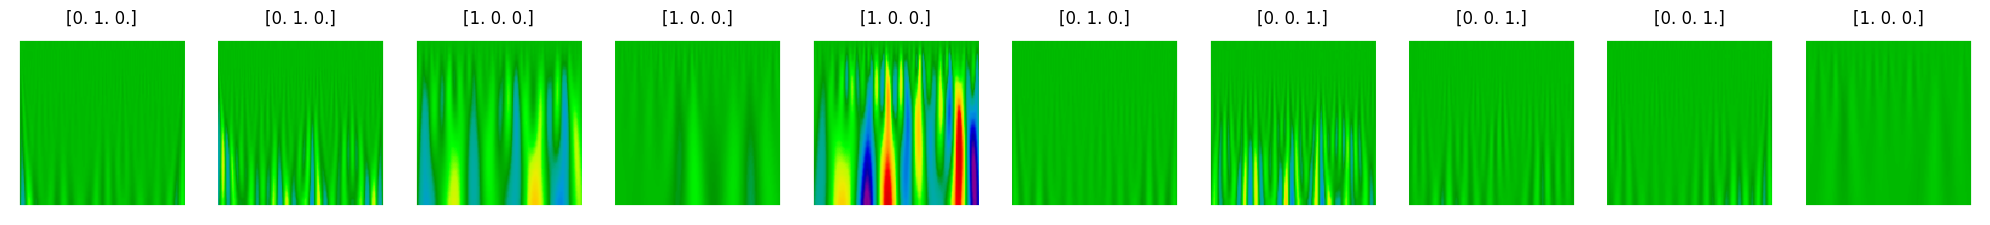

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


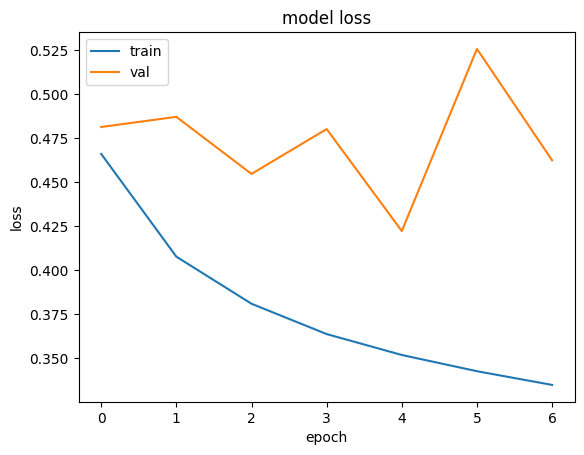

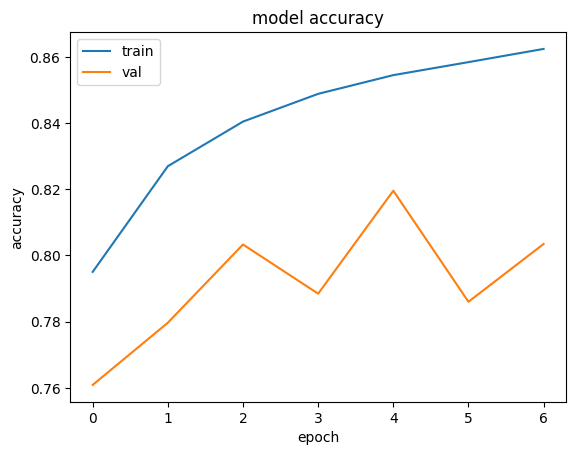

6040/6040 [==============================] - 95s 16ms/step - loss: 1.2714 - dense_4_loss: 0.4215 - dense_1_loss: 0.4276 - dense_3_loss: 0.4223 - dense_4_accuracy: 0.8087 - dense_1_accuracy: 0.7982 - dense_3_accuracy: 0.8091
6040/6040 - 65s - 65s/epoch - 11ms/step
Confusion matrix, without normalization
[[59447  2444  2370]
 [ 1319 12994 10804]
 [  260  2305  4684]]


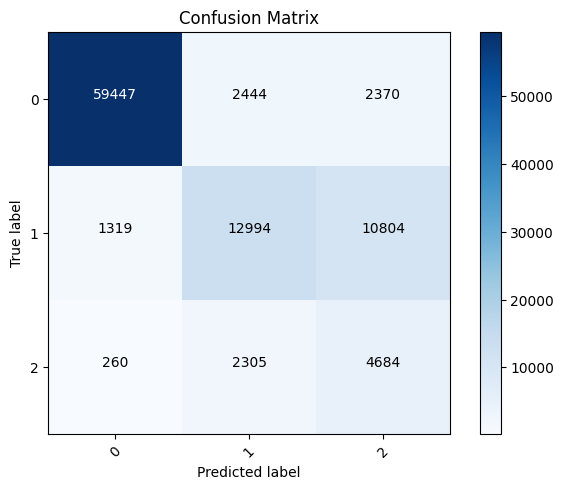

0.798172353482981
              precision    recall  f1-score   support

     class 0    0.97413   0.92509   0.94897     64261
     class 1    0.73235   0.51734   0.60635     25117
     class 2    0.26229   0.64616   0.37312      7249

    accuracy                        0.79817     96627
   macro avg    0.65625   0.69619   0.64281     96627
weighted avg    0.85788   0.79817   0.81671     96627

Epoch 1/30
14174/14174 [==============================] - 1609s 113ms/step - loss: 0.4396 - accuracy: 0.8095 - val_loss: 0.4734 - val_accuracy: 0.7769
Epoch 2/30
14174/14174 [==============================] - 1599s 113ms/step - loss: 0.3777 - accuracy: 0.8412 - val_loss: 0.4794 - val_accuracy: 0.7907
Epoch 3/30
14174/14174 [==============================] - 1593s 112ms/step - loss: 0.3546 - accuracy: 0.8530 - val_loss: 0.5035 - val_accuracy: 0.7862
Epoch 3: early stopping


/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


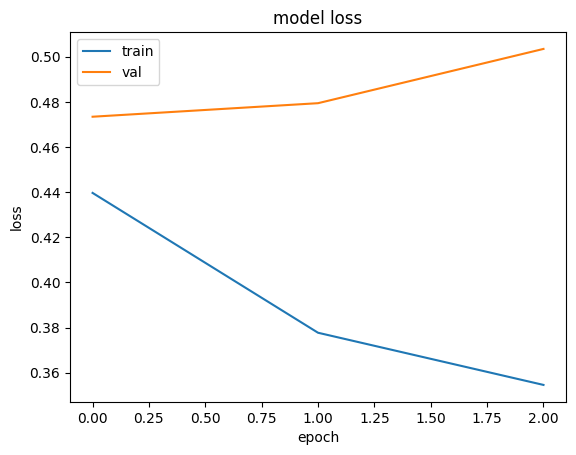

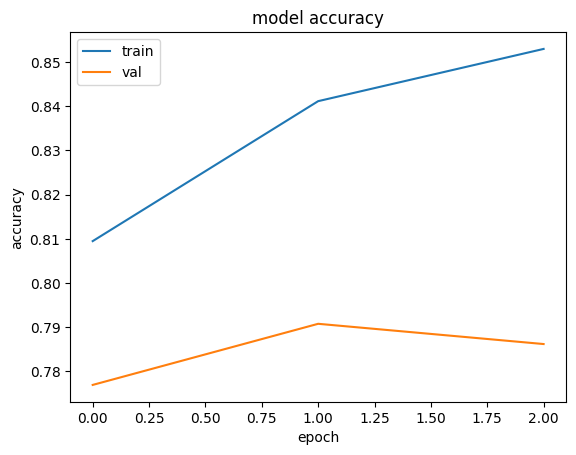

6040/6040 [==============================] - 136s 22ms/step - loss: 0.4367 - accuracy: 0.8019
6040/6040 - 129s - 129s/epoch - 21ms/step
Confusion matrix, without normalization
[[59496  2673  2092]
 [ 1430 13329 10358]
 [  246  2345  4658]]


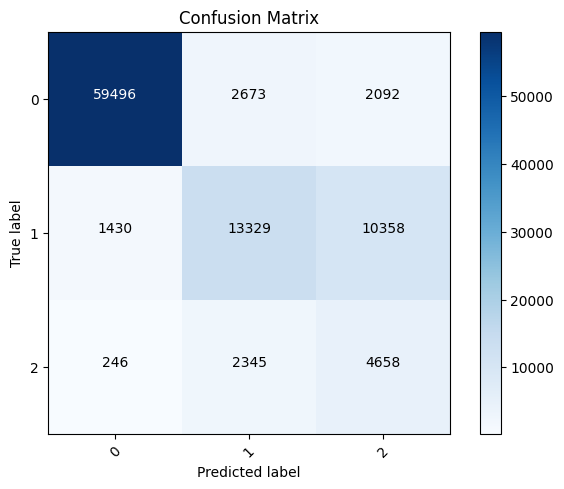

0.8018773220735406
              precision    recall  f1-score   support

     class 0    0.97260   0.92585   0.94865     64261
     class 1    0.72649   0.53068   0.61334     25117
     class 2    0.27227   0.64257   0.38248      7249

    accuracy                        0.80188     96627
   macro avg    0.65712   0.69970   0.64815     96627
weighted avg    0.85609   0.80188   0.81901     96627

------------------- gaus1 -------------------------
Found 452835 images belonging to 3 classes.
Found 66536 images belonging to 3 classes.
Found 96597 images belonging to 3 classes.


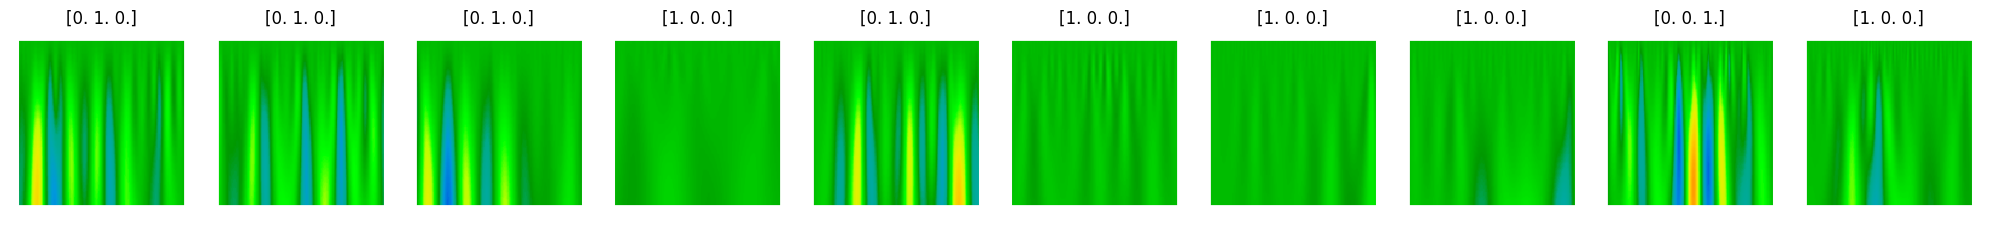

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


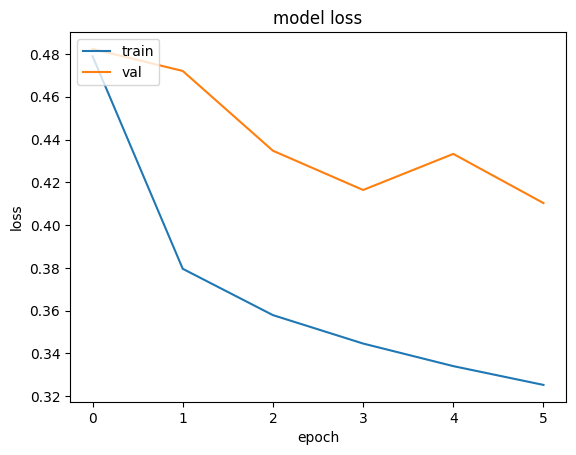

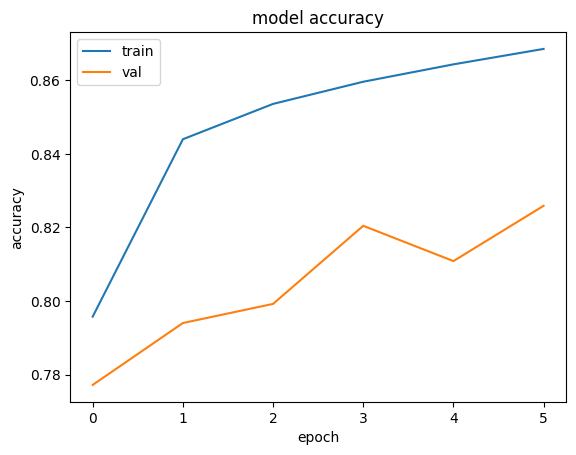

6038/6038 [==============================] - 89s 15ms/step - loss: 1.1042 - dense_4_loss: 0.3655 - dense_1_loss: 0.3714 - dense_3_loss: 0.3672 - dense_4_accuracy: 0.8377 - dense_1_accuracy: 0.8289 - dense_3_accuracy: 0.8342
6038/6038 - 62s - 62s/epoch - 10ms/step
Confusion matrix, without normalization
[[60119  2194  1918]
 [ 2590 15194  7333]
 [  282  2207  4760]]


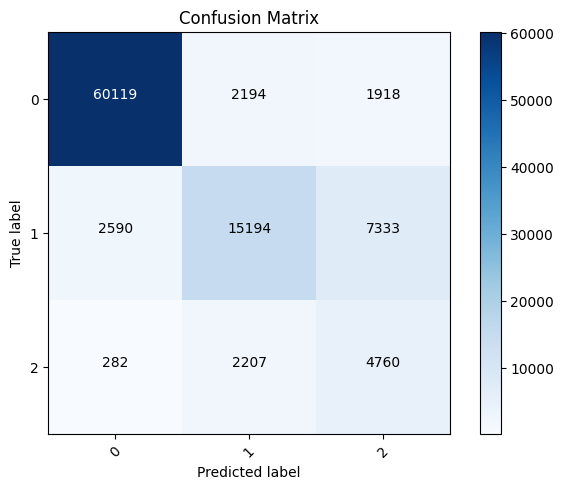

0.8289387869188484
              precision    recall  f1-score   support

     class 0    0.95441   0.93598   0.94510     64231
     class 1    0.77540   0.60493   0.67964     25117
     class 2    0.33973   0.65664   0.44779      7249

    accuracy                        0.82894     96597
   macro avg    0.68985   0.73252   0.69084     96597
weighted avg    0.86173   0.82894   0.83876     96597

Epoch 1/30
14152/14152 [==============================] - 1607s 113ms/step - loss: 0.4127 - accuracy: 0.8294 - val_loss: 0.4356 - val_accuracy: 0.8143
Epoch 2/30
14152/14152 [==============================] - 1591s 112ms/step - loss: 0.3517 - accuracy: 0.8567 - val_loss: 0.4339 - val_accuracy: 0.8099
Epoch 3/30
14152/14152 [==============================] - 1590s 112ms/step - loss: 0.3320 - accuracy: 0.8652 - val_loss: 0.4264 - val_accuracy: 0.8238
Epoch 4/30
14152/14152 [==============================] - 1588s 112ms/step - loss: 0.3190 - accuracy: 0.8711 - val_loss: 0.4173 - val_accuracy: 0.8

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


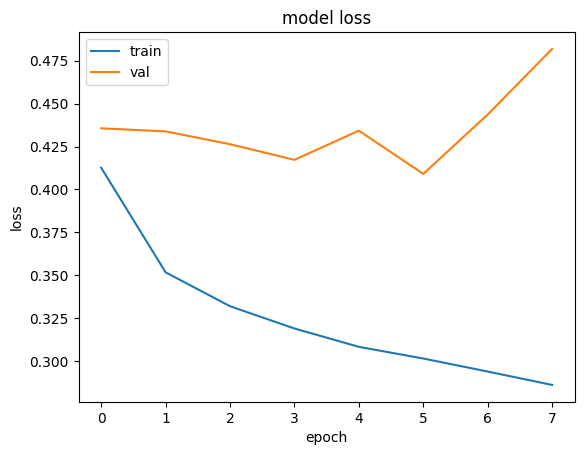

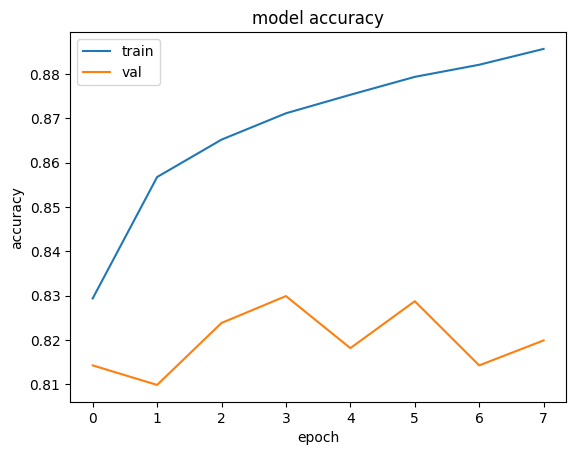

6038/6038 [==============================] - 136s 23ms/step - loss: 0.3860 - accuracy: 0.8365
6038/6038 - 129s - 129s/epoch - 21ms/step
Confusion matrix, without normalization
[[60919  1820  1492]
 [ 4308 15084  5725]
 [  363  2083  4803]]


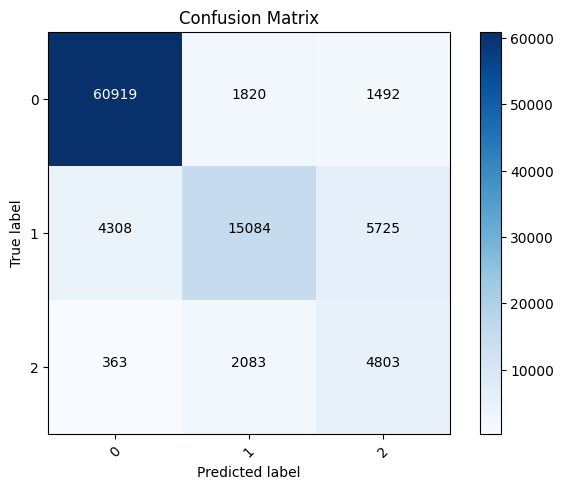

0.8365270142965102
              precision    recall  f1-score   support

     class 0    0.92878   0.94844   0.93851     64231
     class 1    0.79444   0.60055   0.68402     25117
     class 2    0.39958   0.66257   0.49852      7249

    accuracy                        0.83653     96597
   macro avg    0.70760   0.73719   0.70702     96597
weighted avg    0.85414   0.83653   0.83932     96597

------------------- gaus2 -------------------------
Found 452538 images belonging to 3 classes.
Found 66575 images belonging to 3 classes.
Found 96557 images belonging to 3 classes.


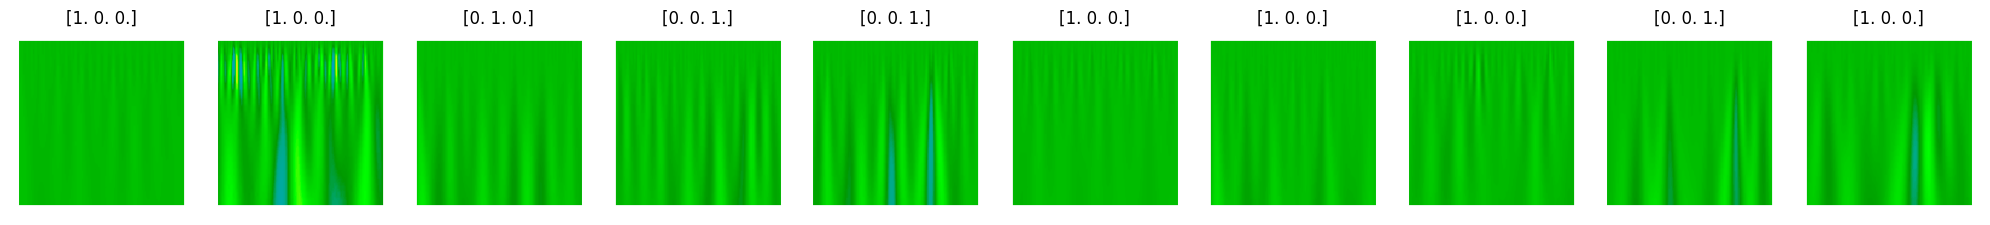

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


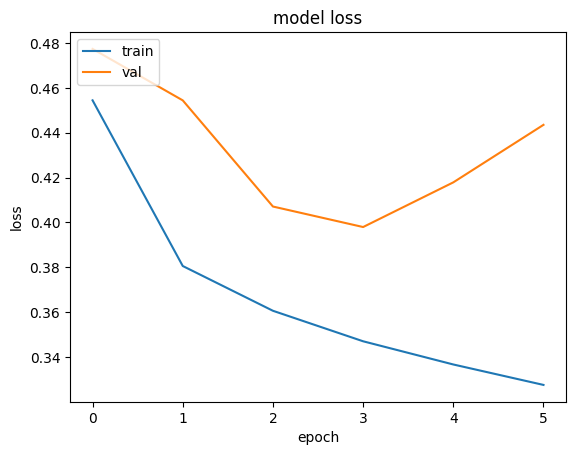

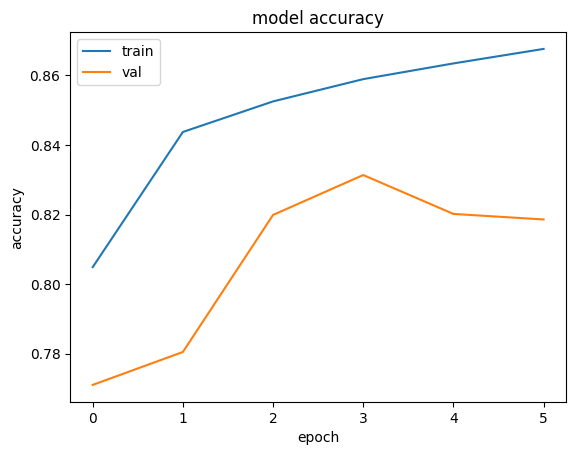

6035/6035 [==============================] - 90s 15ms/step - loss: 1.1247 - dense_4_loss: 0.3789 - dense_1_loss: 0.3713 - dense_3_loss: 0.3745 - dense_4_accuracy: 0.8333 - dense_1_accuracy: 0.8326 - dense_3_accuracy: 0.8366
6035/6035 - 62s - 62s/epoch - 10ms/step
Confusion matrix, without normalization
[[60588  2115  1488]
 [ 2012 15051  8054]
 [  349  2145  4755]]


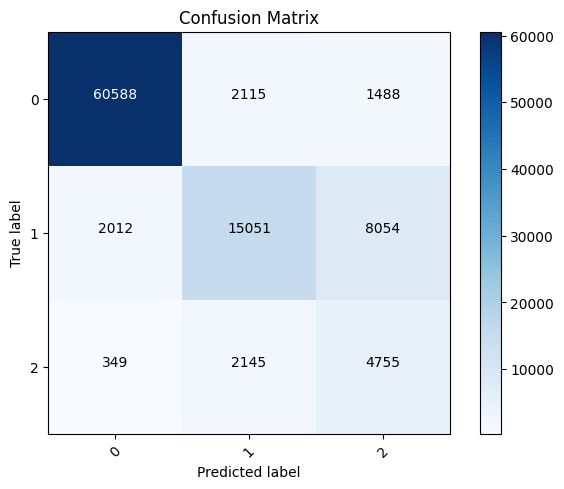

0.8326066468510828
              precision    recall  f1-score   support

     class 0    0.96249   0.94387   0.95309     64191
     class 1    0.77940   0.59924   0.67755     25117
     class 2    0.33259   0.65595   0.44138      7249

    accuracy                        0.83261     96557
   macro avg    0.69149   0.73302   0.69067     96557
weighted avg    0.86758   0.83261   0.84300     96557

Epoch 1/30
14142/14142 [==============================] - 1610s 114ms/step - loss: 0.4093 - accuracy: 0.8306 - val_loss: 0.4275 - val_accuracy: 0.8121
Epoch 2/30
14142/14142 [==============================] - 1590s 112ms/step - loss: 0.3542 - accuracy: 0.8555 - val_loss: 0.4389 - val_accuracy: 0.8174
Epoch 3/30
14142/14142 [==============================] - 1591s 113ms/step - loss: 0.3340 - accuracy: 0.8646 - val_loss: 0.4454 - val_accuracy: 0.8215
Epoch 3: early stopping


/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


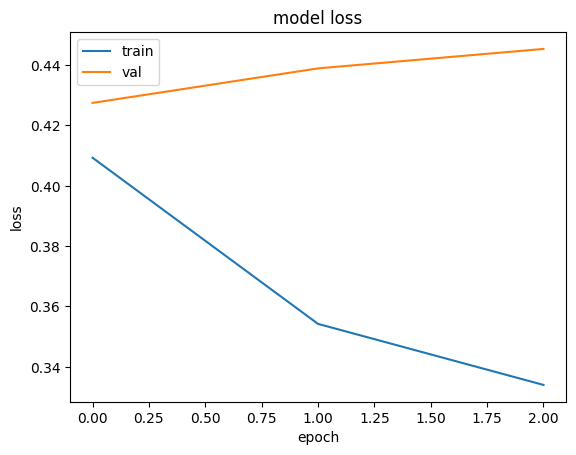

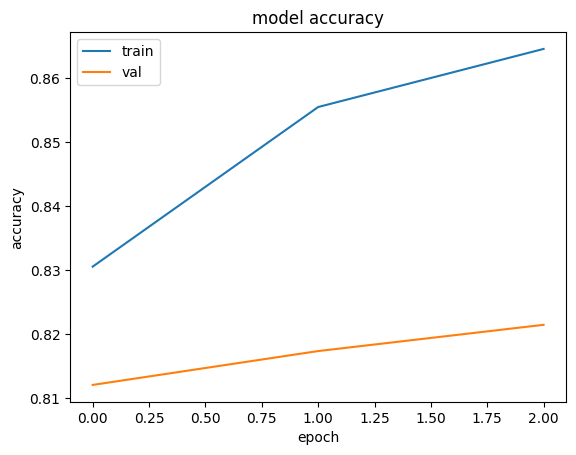

6035/6035 [==============================] - 138s 23ms/step - loss: 0.3788 - accuracy: 0.8394
6035/6035 - 130s - 130s/epoch - 22ms/step
Confusion matrix, without normalization
[[59685  2406  2100]
 [ 1917 16795  6405]
 [  156  2522  4571]]


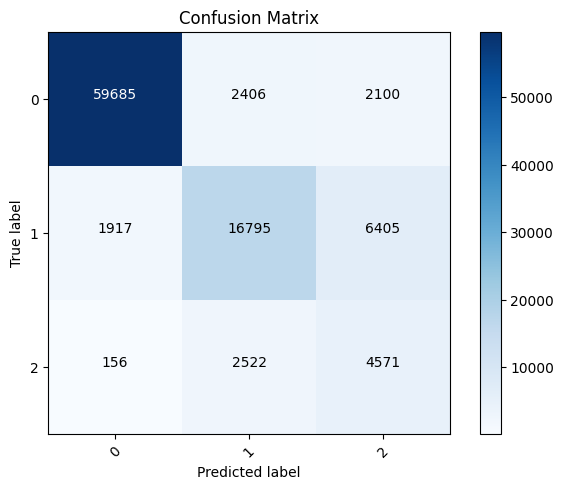

0.8394109179034146
              precision    recall  f1-score   support

     class 0    0.96643   0.92980   0.94776     64191
     class 1    0.77314   0.66867   0.71712     25117
     class 2    0.34957   0.63057   0.44979      7249

    accuracy                        0.83941     96557
   macro avg    0.69638   0.74301   0.70489     96557
weighted avg    0.86984   0.83941   0.85038     96557



In [11]:
for waveletsType in waveletsTypes:
    print("-------------------",waveletsType,"-------------------------")
    checkpoint_filepath = '/home/dll-1/Desktop/eeg/datasets/models/adil/deeplearning/'+waveletsType

    train_path = main_directory +'/'+waveletsType+'/train' + '/'
    valid_path = main_directory +'/'+waveletsType+'/valid' + '/'
    test_path = main_directory +'/'+waveletsType+'/test' + '/'

    train_batches = train_datagen.flow_from_directory(directory = train_path, target_size = (224, 224), classes = class_labels, batch_size = 32, shuffle = True)
    valid_batches = valid_datagen.flow_from_directory(directory = valid_path, target_size = (224, 224), classes = class_labels, batch_size = 16)
    test_batches = test_datagen.flow_from_directory(directory = test_path, target_size = (224, 224), classes = class_labels, batch_size = 16, shuffle = False)

    assert valid_batches.n > 0
    assert test_batches.n > 0
    assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

    imgs, train_labels = next(train_batches)
    plotImages(imgs,train_labels) 

    ##### VGG16

    ###### Import and Build Model

    vgg16_model = keras.applications.vgg16.VGG16()

    vgg16_model_custom = Sequential()
    for layer in vgg16_model.layers[:-1]:
        vgg16_model_custom.add(layer)

    # for layer in model.layers:
    #     layer.trainable = False

    vgg16_model_custom.add(Dense(3, activation = 'softmax'))

    vgg16_model_custom.summary()
    vgg16_model_custom.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])



    google_lenet = GoogLeNet()

    google_lenet.summary()
    google_lenet.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])


    
    google_lenet_model = evaluate_googlenet(google_lenet, train_batches,valid_batches,checkpoint_filepath)
    test_model(google_lenet,test_batches,"googlenet")

    vgg16_model_custom = evaluate_vgg16(vgg16_model_custom, train_batches,valid_batches,checkpoint_filepath)
    test_model(vgg16_model_custom, test_batches,"vgg16")

    